# Data Exploration

The task is to predict the median price of a house on a given district in California, given past records on sold properties in this US state.

In [13]:
# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

sns.set_theme(palette="Set2")

# Load the data

In [14]:
import os
import tarfile
import urllib


# the file is archived with tar and gunzip
URL = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz"

def get_dataframe():
    global URL
    
    # if the "datasets" folder does not exist, create it
    if not os.path.exists("datasets"):
        os.makedirs("datasets")
    
    # if the archived file does not exist, download it
    if not os.path.exists("datasets/housing.tgz"):
        urllib.request.urlretrieve(URL, "datasets/housing.tgz")
    
    # if the unpacked file does not exist, unpack it
    if not os.path.exists("datasets/housing.csv"):
        infile = tarfile.open("datasets/housing.tgz")
        infile.extractall(path="datasets")
        infile.close()
    
    # load the dataframe
    return pd.read_csv("datasets/housing.csv")

In [15]:
df = get_dataframe()

In [16]:
# inspect the first couple of rows
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [17]:
# the size of the dataset
df.shape

(20640, 10)

# Train-test split

## Random sampling

In [18]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=7)
print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

16512 train and 4128 test instances


## Stratified sampling

In [19]:
df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                          labels=[1, 2, 3, 4, 5])

In [20]:
df["income_cat"].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

<Axes: xlabel='income_cat'>

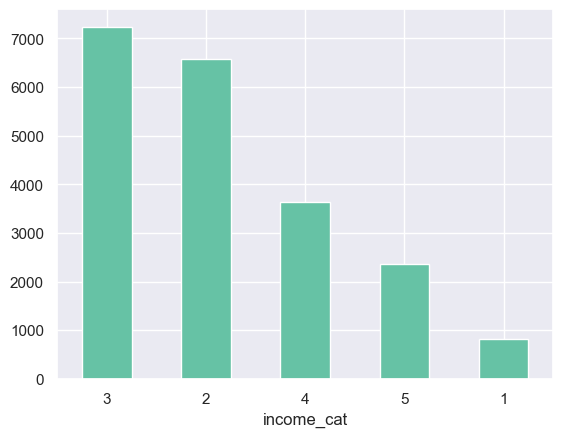

In [21]:
df["income_cat"].value_counts().plot(kind="bar", rot=0)

In [22]:
strat_train_set, strat_test_set = train_test_split(df, test_size=0.2, random_state=7,
                                                  stratify=df["income_cat"])

In [23]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

# create a random split
rand_train_set, rand_test_set = train_test_split(df, test_size=0.2, random_state=7)

# create a temporary dataframe for easy visualization
df_tmp = pd.DataFrame({
    "Overall": income_cat_proportions(df),
    "Random test set": income_cat_proportions(rand_test_set),
    "Stratified test set": income_cat_proportions(strat_test_set),
}).sort_index()

# add two columns for the percent of the difference to the overall proportion
df_tmp["Rand. %error"] = 100 * df_tmp["Random test set"] / df_tmp["Overall"] - 100
df_tmp["Strat. %error"] = 100 * df_tmp["Stratified test set"] / df_tmp["Overall"] - 100

df_tmp

,Overall,Random test set,Stratified test set,Rand. %error,Strat. %error
income_cat,,,,,
1,0.039826,0.039971,0.039971,0.364964,0.364964
2,0.318847,0.297481,0.318798,-6.701109,-0.015195
3,0.350581,0.358043,0.350533,2.128248,-0.013820
4,0.176308,0.188953,0.176357,7.172300,0.027480
5,0.114438,0.115552,0.114341,0.973751,-0.084674


In [24]:
del strat_train_set["income_cat"]
del strat_test_set["income_cat"]

In [25]:
# for convenience, rename the variables to shorter names:
trainset = strat_train_set
testset = strat_test_set

# Univariate analysis

## Columns and their data types

In [26]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 8088 to 2786
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16356 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [27]:
trainset.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16356.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.573100,35.637304,28.698886,2626.351623,535.972243,1418.784944,497.814983,3.867893,207136.547602
std,2.000532,2.133814,12.559323,2147.169862,414.717072,1082.348875,376.209950,1.899566,115413.047088
min,-124.300000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1453.750000,297.000000,790.000000,280.000000,2.558225,119900.000000
50%,-118.500000,34.260000,29.000000,2125.000000,435.000000,1166.500000,409.000000,3.537150,180400.000000
75%,-118.010000,37.720000,37.000000,3136.250000,644.000000,1724.000000,603.000000,4.736900,265125.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100,500001.000000


## Distribution of categorical variables

In [28]:
trainset['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     7307
INLAND        5269
NEAR OCEAN    2114
NEAR BAY      1817
ISLAND           5
Name: count, dtype: int64

<Axes: xlabel='ocean_proximity'>

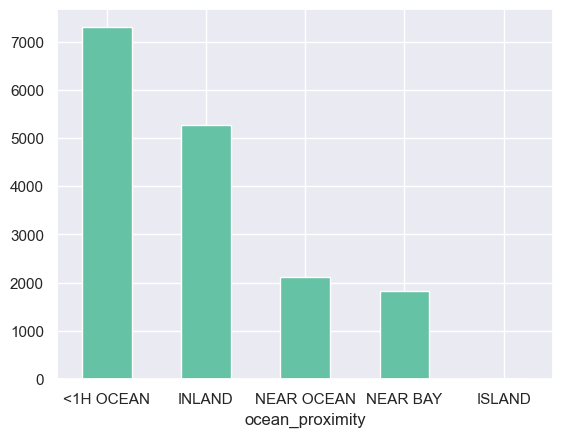

In [31]:
trainset['ocean_proximity'].value_counts().plot(kind="bar", rot=0)

## Distribution of numerical variables

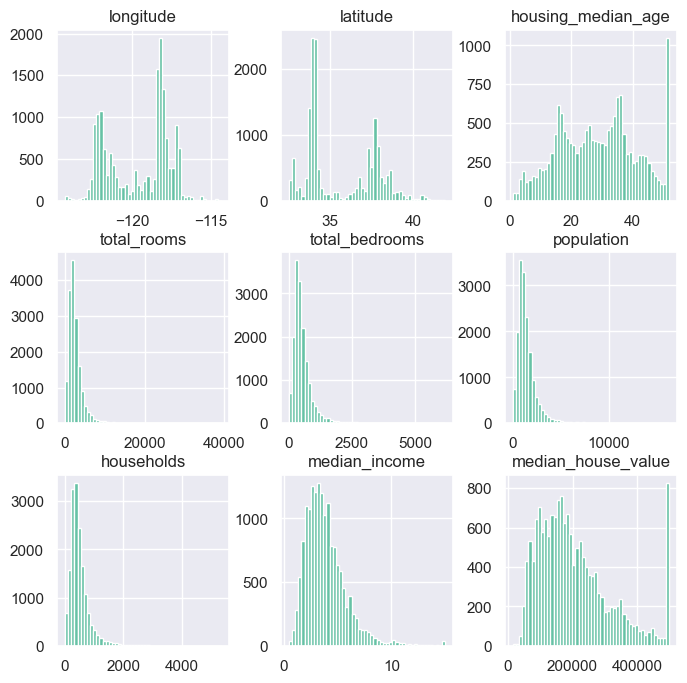

In [35]:
_ = trainset.hist(bins=50, figsize=(8,8))

## Capped values

In [18]:
trainset["median_house_value"].sort_values(ascending=False)

15702    500001.0
5247     500001.0
18339    500001.0
18052    500001.0
10679    500001.0
           ...   
13889     22500.0
5887      17500.0
19802     14999.0
2521      14999.0
2799      14999.0
Name: median_house_value, Length: 16512, dtype: float64

# Bivariate analysis

## Correlation plot

In [49]:
corr_matrix = trainset.corr(method="pearson", numeric_only=True)
corr_matrix.style.background_gradient(cmap='coolwarm', axis=None).format(precision=3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000,-0.924,-0.110,0.046,0.070,0.103,0.056,-0.013,-0.046
latitude,-0.924,1.000,0.011,-0.036,-0.067,-0.113,-0.072,-0.082,-0.146
housing_median_age,-0.110,0.011,1.000,-0.363,-0.320,-0.302,-0.302,-0.117,0.109
total_rooms,0.046,-0.036,-0.363,1.000,0.928,0.861,0.916,0.199,0.136
total_bedrooms,0.070,-0.067,-0.320,0.928,1.000,0.883,0.979,-0.009,0.051
population,0.103,-0.113,-0.302,0.861,0.883,1.000,0.913,0.006,-0.024
households,0.056,-0.072,-0.302,0.916,0.979,0.913,1.000,0.012,0.066
median_income,-0.013,-0.082,-0.117,0.199,-0.009,0.006,0.012,1.000,0.686
median_house_value,-0.046,-0.146,0.109,0.136,0.051,-0.024,0.066,0.686,1.000


## Scatterplots

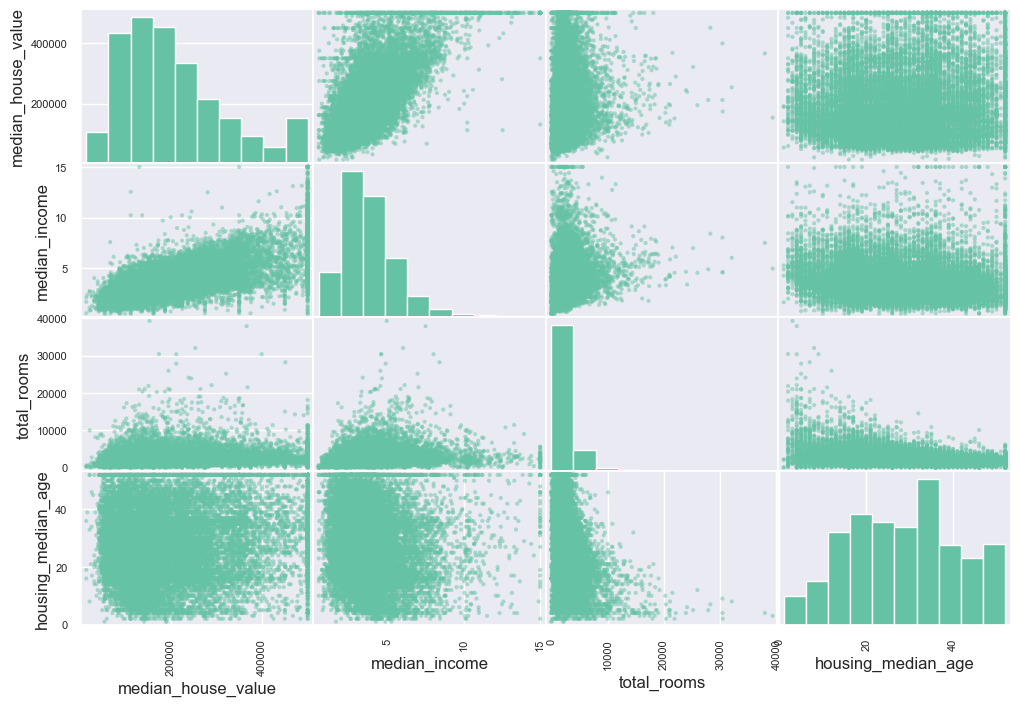

In [41]:
from pandas.plotting import scatter_matrix

# select only the variables that are most likely to be correlated
vars = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
dummy = scatter_matrix(trainset[vars], figsize=(12, 8))

## Correlations with the target variable

In [39]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686289
total_rooms           0.135723
housing_median_age    0.109030
households            0.066404
total_bedrooms        0.050819
population           -0.024405
longitude            -0.045513
latitude             -0.145896
Name: median_house_value, dtype: float64

## Visualizing geographical data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

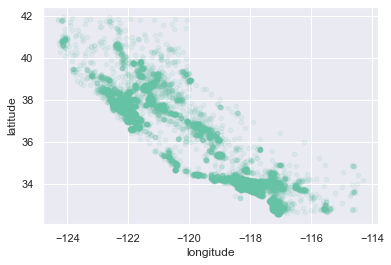

In [19]:
trainset.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

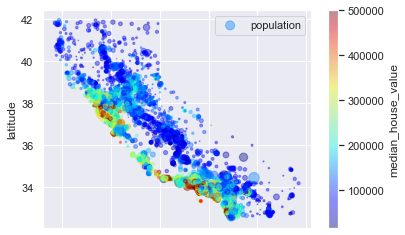

In [20]:
trainset.plot(kind="scatter",
            x="longitude",
            y="latitude", 
            alpha=0.4,                    # transparency
            s=trainset["population"]/100, # radius of each dot: population in the district
            label="population",
            c="median_house_value",       # colour of the dot: house value
            cmap=plt.get_cmap("jet"),    # colour map to use
            colorbar=True,                # show the color map
)

# Acknowledgement

The notebook is based on the code examples from [Aurélien Géron's textbook](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow".

# Citing this notebook

If you use this notebook in your work, please cite it as follows:
    
Pekar, V. (2024). Big Data for Decision Making. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm